In [ ]:
import matplotlib
matplotlib.use("Agg")
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.applications import ResNet152V2
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import os

Using TensorFlow backend.


In [ ]:
def plot_training(H, N):
	# construct a plot that plots and saves the training history
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
	plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
	plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
	plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
	plt.title("Training Loss and Accuracy")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss/Accuracy")
	plt.legend(loc="lower left")
	#plt.savefig(plotPath)

In [ ]:
trainPath = '/content/drive/My Drive/COVID-19/data/train'
testPath = '/content/drive/My Drive/COVID-19/data/test'

totalTrain = len(list(paths.list_images(trainPath)))
totalTest = len(list(paths.list_images(testPath)))

In [ ]:
print(totalTrain)
print(totalTest)

255
64


In [ ]:
trainAug = ImageDataGenerator(
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

testAug = ImageDataGenerator()

In [ ]:
BATCH_SIZE = 32
trainGen = trainAug.flow_from_directory(
	trainPath,
	class_mode="binary",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=True,
	batch_size=BATCH_SIZE)

testGen = testAug.flow_from_directory(
	testPath,
	class_mode="binary",
	target_size=(224, 224),
	color_mode="rgb",
	shuffle=False,
	batch_size=BATCH_SIZE)

Found 255 images belonging to 2 classes.
Found 64 images belonging to 2 classes.


In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)))


headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

In [ ]:
for layer in baseModel.layers:
	layer.trainable = False

In [ ]:
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [ ]:
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=testGen,
	validation_steps=totalTest // BATCH_SIZE,
	epochs=50)

Epoch 1/50
7/7 [==============================] - 163s 23s/step - loss: 4.2907 - accuracy: 0.6368 - val_loss: 0.0128 - val_accuracy: 0.7969
Epoch 2/50
7/7 [==============================] - 29s 4s/step - loss: 1.6138 - accuracy: 0.8430 - val_loss: 2.2754 - val_accuracy: 0.8906
Epoch 3/50
7/7 [==============================] - 8s 1s/step - loss: 0.6669 - accuracy: 0.9462 - val_loss: 0.0294 - val_accuracy: 0.9062
Epoch 4/50
7/7 [==============================] - 8s 1s/step - loss: 0.7578 - accuracy: 0.9241 - val_loss: 0.0045 - val_accuracy: 0.9531
Epoch 5/50
7/7 [==============================] - 8s 1s/step - loss: 0.3730 - accuracy: 0.9686 - val_loss: 0.2618 - val_accuracy: 0.9375
Epoch 6/50
7/7 [==============================] - 8s 1s/step - loss: 0.2762 - accuracy: 0.9821 - val_loss: 0.8085 - val_accuracy: 0.9375
Epoch 7/50
7/7 [==============================] - 8s 1s/step - loss: 0.4412 - accuracy: 0.9596 - val_loss: 0.3689 - val_accuracy: 0.9375
Epoch 8/50
7/7 [=====================

[INFO] evaluating after fine-tuning network head...


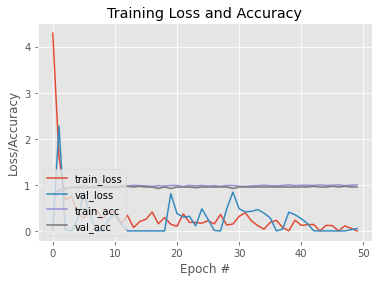

In [ ]:
print("[INFO] evaluating after fine-tuning network head...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // BATCH_SIZE))
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
plot_training(H, 50)

In [ ]:
# reset our data generators
trainGen.reset()
testGen.reset()
# now that the head FC layers have been trained/initialized, lets
# unfreeze the final set of CONV layers and make them trainable
for layer in baseModel.layers[15:]:
	layer.trainable = True
# loop over the layers in the model and show which ones are trainable
# or not
for layer in baseModel.layers:
	print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7fefb01740b8>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb0174128>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb0174390>: False
<keras.layers.pooling.MaxPooling2D object at 0x7fefb01748d0>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb0174710>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb0176400>: False
<keras.layers.pooling.MaxPooling2D object at 0x7fefb0176dd8>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb0176da0>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb017eb00>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb01856a0>: False
<keras.layers.pooling.MaxPooling2D object at 0x7fefb0185eb8>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb0185fd0>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb010dc50>: False
<keras.layers.convolutional.Conv2D object at 0x7fefb01167f0>: False
<keras.layers.pooling.MaxPooling2D object at 0

In [ ]:
print("[INFO] re-compiling model...")
opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# train the model again, this time fine-tuning *both* the final set
# of CONV layers along with our set of FC layers
H = model.fit_generator(
	trainGen,
	steps_per_epoch=totalTrain // BATCH_SIZE,
	validation_data=testGen,
	validation_steps=totalTest // BATCH_SIZE,
	epochs=20)

[INFO] re-compiling model...
Epoch 1/20
7/7 [==============================] - 8s 1s/step - loss: 1.6667e-07 - accuracy: 1.0000 - val_loss: 0.0520 - val_accuracy: 0.9531
Epoch 2/20
7/7 [==============================] - 8s 1s/step - loss: 0.2298 - accuracy: 0.9731 - val_loss: 0.4783 - val_accuracy: 0.9531
Epoch 3/20
7/7 [==============================] - 8s 1s/step - loss: 0.0696 - accuracy: 0.9955 - val_loss: 0.4665 - val_accuracy: 0.9531
Epoch 4/20
7/7 [==============================] - 8s 1s/step - loss: 0.2801 - accuracy: 0.9775 - val_loss: 0.0000e+00 - val_accuracy: 0.9375
Epoch 5/20
7/7 [==============================] - 8s 1s/step - loss: 0.4322 - accuracy: 0.9596 - val_loss: 1.2964e-06 - val_accuracy: 0.9688
Epoch 6/20
7/7 [==============================] - 8s 1s/step - loss: 1.2569 - accuracy: 0.9107 - val_loss: 0.0000e+00 - val_accuracy: 0.9531
Epoch 7/20
7/7 [==============================] - 8s 1s/step - loss: 0.3594 - accuracy: 0.9685 - val_loss: 2.3964 - val_accuracy: 0.9

In [ ]:
print(testGen.classes.shape)
print(testGen.class_indices.keys())
predIdxs.shape


(64,)
dict_keys(['negative', 'positive'])


(96,)

[INFO] evaluating after fine-tuning network...
              precision    recall  f1-score   support

    negative       0.94      0.94      0.94        32
    positive       0.94      0.94      0.94        32

    accuracy                           0.94        64
   macro avg       0.94      0.94      0.94        64
weighted avg       0.94      0.94      0.94        64



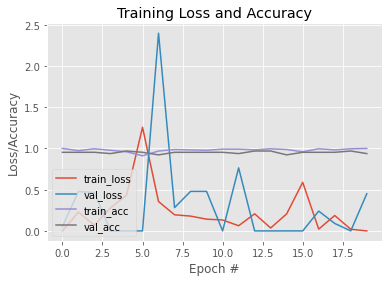

In [ ]:
print("[INFO] evaluating after fine-tuning network...")
testGen.reset()
predIdxs = model.predict_generator(testGen,
	steps=(totalTest // BATCH_SIZE))
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testGen.classes, predIdxs,
	target_names=testGen.class_indices.keys()))
plot_training(H, 20)